In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from os import path

In [32]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual' or 'automated' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated"):
        break
    print("Invalid argument")

Please enter 'manual' or 'automated' for the type of data set you are processing: manual


In [33]:
# Ask user if running analysis on a new cruise
while (True):
    reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Are you running the analysis on a new cruise? (y/n): n


In [34]:
# first call bash script to get necessary file inputs
# for geographic script, choose query_samples for underway gps data alignment as input script
# for worms script, choose names_ids.csv for input script
# only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
if ( not reply[0] != 'y' or not (path.exists('resolved_auto.csv') 
        and path.exists('resolved_manual.csv' and path.exists('comparison.csv')))):
    subprocess.call(['./exec.sh', reply[0]])

In [35]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['permalink', 'namespace_manual', 'worms_higher_order_manual', 'Biovolume', 'MajorAxisLength']
else:
    columns = ['permalink', 'namespace_automated', 'Biovolume', 'MajorAxisLength']

In [36]:
# read in level 1_b file
all_rois = pd.read_csv('level_1b.csv', usecols=columns)

In [37]:
# prompt user to ask for desired size distribution, keep at 20 for now
threshold = input('Please enter minimum Major Axis Length to analyze (micrometers): ')
threshold = float(threshold)

Please enter minimum Major Axis Length to analyze (micrometers): 40


In [38]:
# get higher order data if dataset is automated
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    all_rois.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
else:
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')

In [39]:
# separate out roi id from permalink
all_rois['roi'] = all_rois['permalink']
all_rois.roi = all_rois.roi.str.slice(68, 74)
# gets rid of leading zeros
all_rois.roi = all_rois.roi.str.lstrip("0")
# cut permalink to just be permalink of sample
all_rois.permalink = all_rois.permalink.str.slice(0, 67)

In [40]:
# read in gps coordinates file
coords = pd.read_csv('comparison.csv', usecols=['pid', 'gps_furuno_latitude'])
# merge with all_rois based on smaple ids
all_rois = pd.merge(all_rois, coords, how='left', left_on='permalink', right_on='pid')

In [41]:
# first exclude abiotic particles
all_rois = all_rois[all_rois['alt_datasource'] != "OCB"]
# calculate total biovolume per sample
total = all_rois.groupby('permalink')['Biovolume'].sum().reset_index()
total.rename(columns={'Biovolume':'total_biovolume'}, inplace=True)
# merge 2 data frames based on sample_identifier
all_rois = pd.merge(all_rois, total, how='left', on='permalink')

In [42]:
# filter out rows below threshold
all_rois = all_rois[all_rois.MajorAxisLength > threshold]

In [43]:
# group by sample identifiers and higher ranks to calculate total biovolume per ranking
all_rois = all_rois.groupby(
    ['permalink', 'worms_higher_order_{}'.format(dataset_type)]).agg(
    {
        'Biovolume': 'sum',
        'gps_furuno_latitude': 'first',
        'total_biovolume': 'first'
    }
).reset_index()
# calculate percent biovolume
all_rois['percent_biovolume'] = all_rois['Biovolume']/all_rois['total_biovolume']

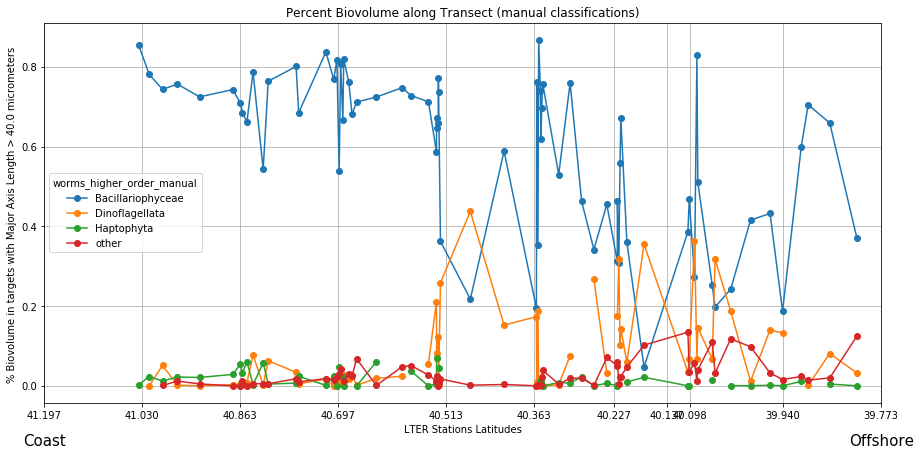

In [44]:
# take duplicate latitudes and add their concentrations together to make percent biovolume plot
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
rois = all_rois.groupby(['gps_furuno_latitude','worms_higher_order_{}'.format(dataset_type)]).sum()['percent_biovolume']
rois.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes')
plt.ylabel('% Biovolume in targets with Major Axis Length > {} micrometers '.format(threshold))
plt.title('Percent Biovolume along Transect ({} classifications)'.format(dataset_type))
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# ax.set_xticklabels(np.arange(1,12))
# set comments
ax.text(41.1967, -0.15, "Coast", size = 15, ha = 'center')
ax.text(39.7733, -0.15, "Offshore", size = 15, ha = 'center')
# invert x axis
ax.invert_xaxis()
plt.show()

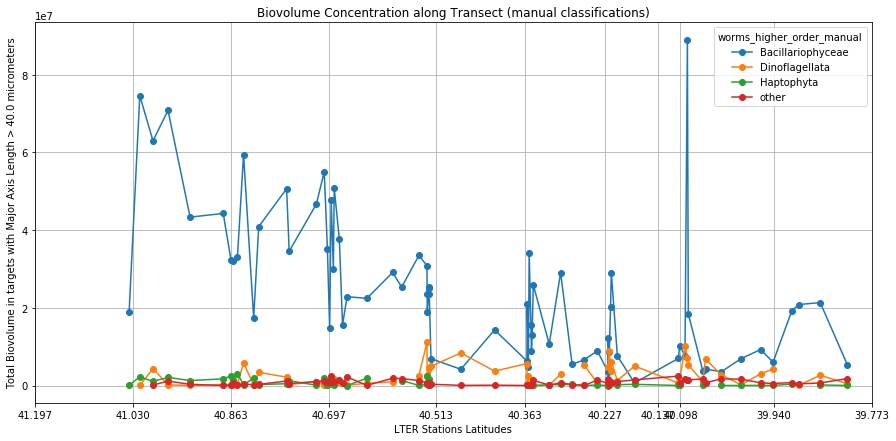

In [45]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
rois = all_rois.groupby(['gps_furuno_latitude','worms_higher_order_{}'.format(dataset_type)]).sum()['Biovolume']
rois.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes')
plt.ylabel('Total Biovolume in targets with Major Axis Length > {} micrometers'.format(threshold))
plt.title('Biovolume Concentration along Transect ({} classifications)'.format(dataset_type))
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# invert x axis
ax.invert_xaxis()
plt.show()